In [1]:
from datetime import timedelta
import numpy as np
from time import time
import sys

In [2]:
from lib.data import load_data

start = time()
X, y = load_data('data.csv')
end = time()
print 'Data loading done in', timedelta(seconds=end - start)

Data loading done in 0:00:14.044789


In [3]:
data_size = 80000
start = time()
X_normal = X[y == 0]
X_fraud = X[y == 1]
y_normal = y[y == 0]
y_fraud = y[y == 1]
idx = np.random.randint(y_normal.size, size=data_size)
X = np.concatenate((X_normal[idx], X_fraud), axis=0)
y = np.concatenate((y_normal[idx], y_fraud), axis=0)
end = time()
print 'Data reduction done in', timedelta(seconds=end - start)

Data reduction done in 0:00:00.497813


In [4]:
from imblearn.over_sampling import SMOTE 

start = time()
sm = SMOTE(random_state=0)
X_sm, y_sm = sm.fit_sample(X, y)
end = time()
print 'SMOTE done in', timedelta(seconds=end - start)

SMOTE done in 0:00:00.938895


In [5]:
from sklearn.model_selection import train_test_split

start = time()
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.1, random_state=0)
end = time()
print 'Data splitting done in', timedelta(seconds=end - start)

Data splitting done in 0:00:00.021690


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve

start = time()
C = 1000
train_sizes = np.linspace(0.01, 1, 20)
clf = LogisticRegression(C=C)
train_sizes, train_scores, cv_scores = learning_curve(clf, X_train, y_train,
                                                      scoring='accuracy', train_sizes=train_sizes,
                                                      n_jobs=2)
end = time()
print 'Learning curve done in', timedelta(seconds=end - start)

Learning curve done in 0:00:17.267396


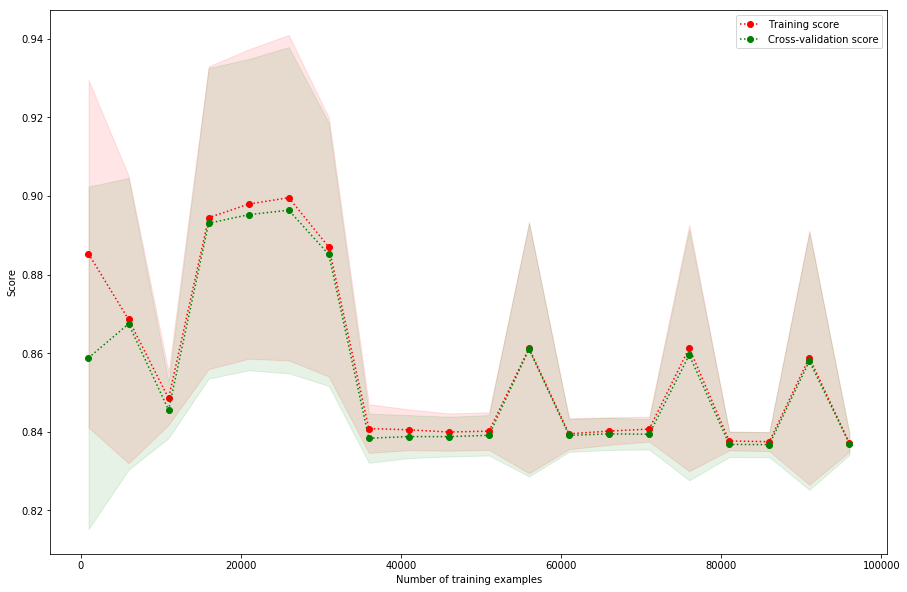

In [7]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15.0, 10.0]

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
cv_scores_mean = np.mean(cv_scores, axis=1)
cv_scores_std = np.std(cv_scores, axis=1)

plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                 alpha=0.1, color='r')
plt.plot(train_sizes, train_scores_mean, ':or', label='Training score')
plt.fill_between(train_sizes,
                 cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std,
                 alpha=0.1, color='g')
plt.plot(train_sizes, cv_scores_mean, ':og', label='Cross-validation score')
plt.xlabel('Number of training examples')
plt.ylabel('Score')
plt.legend()
plt.show()

In [8]:
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

start = time()
try:
    grid = joblib.load('SMOTE+LogitReg.pkl')
    end = time()
    print 'Model loaded in', timedelta(seconds=end - start)
except IOError:
    poly = PolynomialFeatures(include_bias=False)
    scaler = StandardScaler()
    logit_reg = LogisticRegression()
    pipe = Pipeline([('poly', poly), ('scaler', scaler), ('logit_reg', logit_reg)])

    param_grid = {
        'logit_reg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'poly__degree': [2, 3, 4, 5]
    }
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring='accuracy', n_jobs=2)

    grid.fit(X_train, y_train)
    end = time()
    print 'Hyper-parameter tuning done in', timedelta(seconds=end - start)
    joblib.dump(grid, 'SMOTE+LogitReg.pkl')

Hyper-parameter tuning done in 0:55:08.085024


In [9]:
print grid.best_params_
print grid.best_score_

{'poly__degree': 2, 'logit_reg__C': 1000}
0.983777777778


In [10]:
from sklearn.metrics import accuracy_score

y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print 'Test accuracy: {}'.format(accuracy)

Test accuracy: 0.9840625
